In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

%matplotlib inline

# Import data
df = pd.read_csv("data/data_cummulative.csv");

# Set user groups from enabled features

# Abbreviations:
# - BG: User got no explanations (base group).
# - AE: User got explanations about the routing algorithm (alogorithm explanations).
# - NE: User got explanations depending on the active navigation (navigation explanations).
# - GE: User got both types of explanations (grouped explanations).

df.loc[(df['LowAccuracyCounter'].isna()), 'LowAccuracyCounter'] = 0
df.loc[(df['MaxLowAccuracy'].isna()), 'MaxLowAccuracy'] = 0
df.loc[(df['NumberOfUnnormalRoutes'].isna()), 'NumberOfUnnormalRoutes'] = 0
df.loc[(df['OffRoutePerTenKilometers'].isna()), 'OffRoutePerTenKilometers'] = 0
df.loc[(df['DistanceTraveledInMeters'].isna()), 'DistanceTraveledInMeters'] = 0
df.loc[(df['NumberOfTimesSeenUserCountExplanationShort'].isna()), 'NumberOfTimesSeenUserCountExplanationShort'] = 0
df.loc[(df['NumberOfTimesSeenUserCountExplanationLong'].isna()), 'NumberOfTimesSeenUserCountExplanationLong'] = 0
df.loc[(df['NumberOfTimesSeenCollaborativeRoutingExplanation'].isna()), 'NumberOfTimesSeenCollaborativeRoutingExplanation'] = 0

df["LowAccuracyPerKilometer"] = df["LowAccuracyCounter"] / (df["DistanceTraveledInMeters"] / 1000)
df.loc[(df['LowAccuracyPerKilometer'].isna()), 'LowAccuracyPerKilometer'] = 0

df.loc[(df['GpsQuality'] == False) & (df['TrafficVolume'] == False) & (df['RouteExplanation'] == False) & (df['UserCount'] == False), 'task'] = "BG"
df.loc[(df['GpsQuality'] == False) & (df['TrafficVolume'] == False) & (df['RouteExplanation'] == True) & (df['UserCount'] == True), 'task'] = "AE"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['MaxLowAccuracy'] > 0) | (df['NumberOfUnnormalRoutes'] > 0)) & (df['RouteExplanation'] == False) & (df['UserCount'] == False), 'task'] = "NE"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['MaxLowAccuracy'] > 0) | (df['NumberOfUnnormalRoutes'] > 0)) & (df['RouteExplanation'] == True) & (df['UserCount'] == True), 'task'] = "GE"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['MaxLowAccuracy'] <= 0) & (df['NumberOfUnnormalRoutes'] <= 0)) & (df['RouteExplanation'] == False) & (df['UserCount'] == False), 'task'] = "BG"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['MaxLowAccuracy'] <= 0) & (df['NumberOfUnnormalRoutes'] <= 0)) & (df['RouteExplanation'] == True) & (df['UserCount'] == True), 'task'] = "AE"

df.loc[(df['task'] == "BG"), 'group_named'] = "Gruppe 1"
df.loc[(df['task'] == "AE"), 'group_named'] = "Gruppe 2"
df.loc[(df['task'] == "NE"), 'group_named'] = "Gruppe 3"
df.loc[(df['task'] == "GE"), 'group_named'] = "Gruppe 4"

df = df[df['task'].notna()]

# Remove fields with redundant information
df = df.drop(columns=['GpsQuality', 'TrafficVolume', 'RouteExplanation', 'UserCount'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41540 entries, 0 to 41539
Data columns (total 17 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   DeviceId                                          41540 non-null  object 
 1   numberOfRoutes                                    41540 non-null  int64  
 2   InitialTrafficVolume                              41540 non-null  object 
 3   DistanceTraveledInMeters                          41540 non-null  int64  
 4   OffRoutePerTenKilometers                          41540 non-null  float64
 5   LowAccuracyCounter                                41540 non-null  int64  
 6   Rating                                            696 non-null    float64
 7   NumberOfTimesSeenUserCountExplanationShort        41540 non-null  float64
 8   NumberOfTimesSeenUserCountExplanationLong         41540 non-null  float64
 9   NumberOfTimesSeen

In [2]:
g = df.groupby(['DeviceId']).sum()
grouped_data_raw = g.reset_index()
grouped_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9590 entries, 0 to 9589
Data columns (total 14 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   DeviceId                                          9590 non-null   object 
 1   numberOfRoutes                                    9590 non-null   int64  
 2   DistanceTraveledInMeters                          9590 non-null   int64  
 3   OffRoutePerTenKilometers                          9590 non-null   float64
 4   LowAccuracyCounter                                9590 non-null   int64  
 5   Rating                                            9590 non-null   float64
 6   NumberOfTimesSeenUserCountExplanationShort        9590 non-null   float64
 7   NumberOfTimesSeenUserCountExplanationLong         9590 non-null   float64
 8   NumberOfTimesSeenCollaborativeRoutingExplanation  9590 non-null   float64
 9   ActualDrivingTime  

In [3]:
# Filter for unusable data
filtered_data = df

filtered_data = filtered_data[filtered_data['DistanceTraveledInMeters']>5000]

filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16531 entries, 1 to 41528
Data columns (total 17 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   DeviceId                                          16531 non-null  object 
 1   numberOfRoutes                                    16531 non-null  int64  
 2   InitialTrafficVolume                              16531 non-null  object 
 3   DistanceTraveledInMeters                          16531 non-null  int64  
 4   OffRoutePerTenKilometers                          16531 non-null  float64
 5   LowAccuracyCounter                                16531 non-null  int64  
 6   Rating                                            625 non-null    float64
 7   NumberOfTimesSeenUserCountExplanationShort        16531 non-null  float64
 8   NumberOfTimesSeenUserCountExplanationLong         16531 non-null  float64
 9   NumberOfTimesSeen

In [4]:
#g = filtered_data.groupby(['DeviceId', 'task']).mean()
#grouped_data_filtered = g.reset_index()

g = filtered_data.groupby(['DeviceId', 'task', 'group_named']).agg(numberOfRoutes=('DeviceId', 'count'))
grouped_data_filtered = g.reset_index()

grouped_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4012 entries, 0 to 4011
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DeviceId        4012 non-null   object
 1   task            4012 non-null   object
 2   group_named     4012 non-null   object
 3   numberOfRoutes  4012 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.5+ KB


In [5]:
g = grouped_data_filtered.groupby('group_named')["DeviceId"].count()
grouped_data_task = g.reset_index()
grouped_data_task.head()

,group_named,DeviceId
0,Gruppe 1,1778
1,Gruppe 2,1397
2,Gruppe 3,468
3,Gruppe 4,369


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

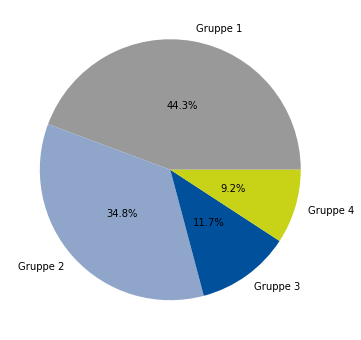

In [6]:
chartColors=["#999999", "#8FA6CA", "#00509B", "#C8D317", "#EE6429", "#E4AF8E"]
labels = grouped_data_task.group_named.sort_values()

pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=grouped_data_task["DeviceId"], autopct="%.1f%%", labels=labels, pctdistance=0.5, colors=chartColors)
plt

In [7]:
or_data = grouped_data_filtered

In [8]:
# Remove outliers
#
# > An outlier of a dataset is defined as a value that is more than 3 standard deviations from the mean.
# > Removing outliers from a pandas.DataFrame removes any rows in the DataFrame which contain an outlier.
# > Outlier calculations are performed separately for each column.

or_data = or_data[np.abs(or_data.numberOfRoutes-or_data.numberOfRoutes.median())<=(3*or_data.numberOfRoutes.std())]

or_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 0 to 4011
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DeviceId        3937 non-null   object
 1   task            3937 non-null   object
 2   group_named     3937 non-null   object
 3   numberOfRoutes  3937 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 153.8+ KB


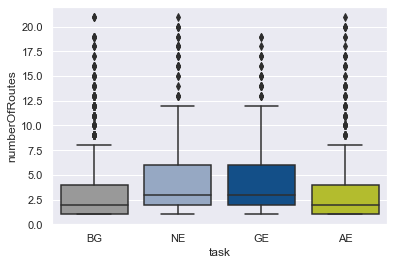

In [9]:
sns.set()
sns.boxplot(data=or_data, x=or_data.task, y=or_data.numberOfRoutes, palette=chartColors)
plt.savefig('usage_result_overview.pdf')
plt.show()

In [10]:
#Test groups for normality.

experiments = ["BG", "AE", "NE", "GE"]

for e in experiments:
    print("Task ", e, " normality result: ", st.shapiro(or_data[or_data.task==e].numberOfRoutes))
    print("Variance: ", or_data[or_data.task == e].numberOfRoutes.var())


Task  BG  normality result:  ShapiroResult(statistic=0.6933990716934204, pvalue=0.0)
Variance:  10.041301120434525
Task  AE  normality result:  ShapiroResult(statistic=0.6918646097183228, pvalue=1.401298464324817e-44)
Variance:  9.690603322524112
Task  NE  normality result:  ShapiroResult(statistic=0.7574802041053772, pvalue=4.599604870577299e-25)
Variance:  18.068863245267735
Task  GE  normality result:  ShapiroResult(statistic=0.8087303638458252, pvalue=3.3011143272811835e-20)
Variance:  15.497578730811837


p < 0.05 -> we can reject the 0-Hypotheses.

Groups are not normally distributed thus we have to take Kruskal Wallis instead of ANONVA

In [11]:
import pingouin as pg

res = pg.kruskal(data=or_data, dv='numberOfRoutes', between='task')

print(res)

        Source  ddof1          H         p-unc
Kruskal   task      3  72.392588  1.311644e-15


p < 0.05 --> we can reject the 0-Hypothesis.

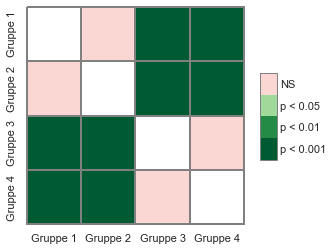

              Gruppe 1      Gruppe 2      Gruppe 3      Gruppe 4
Gruppe 1  1.000000e+00  1.000000e+00  4.746580e-09  7.528428e-09
Gruppe 2  1.000000e+00  1.000000e+00  1.977438e-08  2.523727e-08
Gruppe 3  4.746580e-09  1.977438e-08  1.000000e+00  1.000000e+00
Gruppe 4  7.528428e-09  2.523727e-08  1.000000e+00  1.000000e+00
Mean BG:  3.2233618233618233 BG:  2.0  STD:  3.1688012118835296 
Mean AE:  3.1976828385228098 AE:  2.0  STD:  3.1129733893054903 
Mean NE:  4.4224719101123595 NE:  3.0  STD:  4.250748551169281 
Mean GE:  4.438202247191011 GE:  3.0  STD:  3.9366964235017967 


In [12]:
import scipy.stats as st
import scikit_posthocs as sp
from statsmodels.stats.anova import AnovaRM

#pairwise testing:

pc = sp.posthoc_dunn(or_data, val_col="numberOfRoutes", group_col='group_named', p_adjust="bonferroni")


heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)
plt.savefig('usage_result_significance.pdf')
plt.show()
print(pc)

print("Mean BG: ", or_data[or_data.task == "BG"].numberOfRoutes.mean(), "BG: ", or_data[or_data.task == "BG"].numberOfRoutes.median(), " STD: ", or_data[or_data.task == "BG"].numberOfRoutes.std(),"")
print("Mean AE: ", or_data[or_data.task == "AE"].numberOfRoutes.mean(), "AE: ", or_data[or_data.task == "AE"].numberOfRoutes.median(), " STD: ", or_data[or_data.task == "AE"].numberOfRoutes.std(),"")
print("Mean NE: ", or_data[or_data.task == "NE"].numberOfRoutes.mean(), "NE: ", or_data[or_data.task == "NE"].numberOfRoutes.median(), " STD: ", or_data[or_data.task == "NE"].numberOfRoutes.std(),"")
print("Mean GE: ", or_data[or_data.task == "GE"].numberOfRoutes.mean(), "GE: ", or_data[or_data.task == "GE"].numberOfRoutes.median(), " STD: ", or_data[or_data.task == "GE"].numberOfRoutes.std(),"")
